# Segmentation

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage import data, io, color
from PIL import Image

### Load Image

In [36]:
# read image
image_original = io.imread('13d_400_edited.tif')
image_grain = io.imread('13d_400_grain.tif')
image_brine = io.imread('13d_400_brine_hydrate.tif') 
image_grain_and_brine = io.imread('13d_400_grain_brine_hydrate.tif')
# image properties
print('Geometry of image (z,x,y) is', image_original.shape)
print('Image intensity range is from',image_original.min(),'to',image_original.max())

Geometry of image (z,x,y) is (693, 693)
Image intensity range is from 0 to 65535


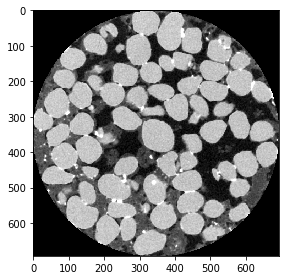

In [3]:
# show image
io.imshow(image_original)

### 3D Grayscale Coordinate Convention

In [4]:
x = 350
y = 450
value = image_original[x,y]
print('Grayscale value is',value,'at [',x,y,']')

Grayscale value is 49777 at [ 350 450 ]


### Create Subvolume

Geometry of image (z,x,y) is (100, 100)
Image intensity range is from 0 to 65535


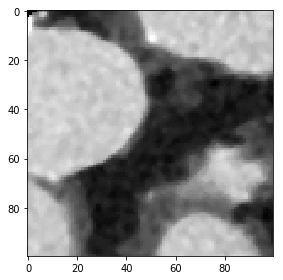

In [5]:
subvolume = image_original[100:200,100:200]
print('Geometry of image (z,x,y) is', subvolume.shape)
print('Image intensity range is from',subvolume.min(),'to',subvolume.max())
io.imshow(subvolume)

### Create Segmented Image (without Salinity Calculation)

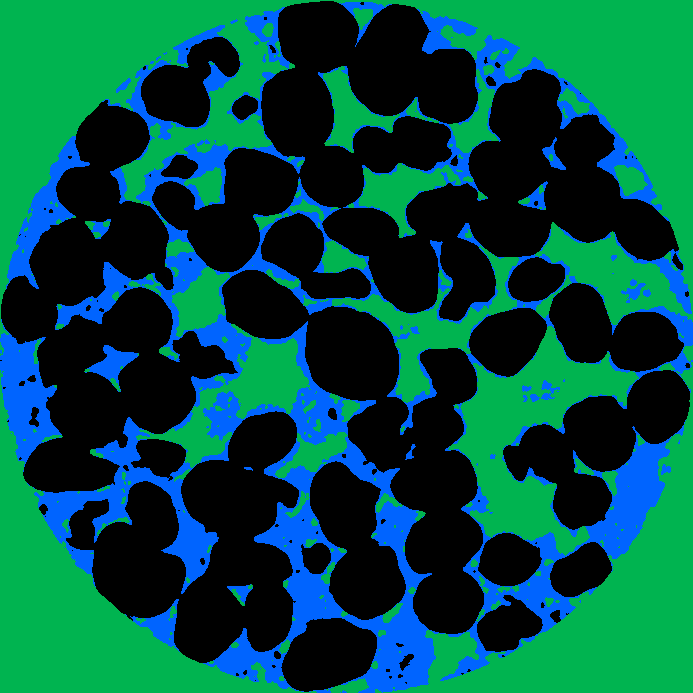

In [6]:
height, width = image_original.shape
rgbArray1 = np.zeros((height,width,3), 'uint8')

gas = 13107; # grayscale threshold for gas
grain = 32639; # grayscale threshold for grain

for i in range(height):
    for j in range(width):
        if image_original[i,j] > gas and image_original[i,j] < grain: # set brine = blue
            rgbArray1[i,j,0] = 0
            rgbArray1[i,j,1] = 100
            rgbArray1[i,j,2] = 255   
        if image_original[i,j] < gas: # set gas = green
            rgbArray1[i,j,0] = 0 
            rgbArray1[i,j,1] = 180
            rgbArray1[i,j,2] = 80
        if image_grain[i,j] == 255: # set grains = black
            rgbArray1[i,j,0] = 0
            rgbArray1[i,j,1] = 0
            rgbArray1[i,j,2] = 0    
            
segmented1 = Image.fromarray(rgbArray1)
segmented1.save('13d_400_seg.png')
segmented1

### Create Segmented Image (with Salinity Calculation)

In this method we segment the brine/hydrate and grain phases separately to remove the grain coating artifact. The grain phase is dilated using Fiji/ImageJ. 

In [28]:
height, width = image_original.shape
rgbArray2 = np.zeros((height,width,3), 'uint8')

num = 7 # number of divisions for discrete color bar
gas = 13107; # grayscale threshold for gas
grain = 32639; # grayscale threshold for grain

array_KI = np.linspace(0,6,num) # array for KI cutoffs
array_r = np.linspace(255,0,num) # array for r cutoffs of discrete color map
array_g = np.linspace(255,100,num) # array for g cutoffs of discrete color map
array_b = np.linspace(255,255,num) # array for b cutoffs of discrete color map

ct_sand = 51000
ct_sand_calibration = 23500
offset = 3690
array_gs = np.round((array_KI * 1972 + 7445) * (ct_sand/ct_sand_calibration) + offset,0) 
    # array for grayscale cutoffs, from calibration
    # adjusted by a multiplier since mean gs of sand is different than mean gs of sand from calibration
    # adjusted by a offset to match the scaling calibration equation at bulk wt% of 4.4 KI
#array_gs = np.linspace(gas,grain,num)
    # array for grayscale cutoffs, using idealized linear scale

df = pd.DataFrame({'Grayscale':array_gs,'Bulk wt% of KI':array_KI,'R':array_r,'G':array_g,'B':array_b})
df.head(num)

Grayscale  Bulk wt% of KI      R           G      B
0    19847.0             0.0  255.0  255.000000  255.0
1    24127.0             1.0  212.5  229.166667  255.0
2    28407.0             2.0  170.0  203.333333  255.0
3    32686.0             3.0  127.5  177.500000  255.0
4    36966.0             4.0   85.0  151.666667  255.0
5    41246.0             5.0   42.5  125.833333  255.0
6    45525.0             6.0    0.0  100.000000  255.0

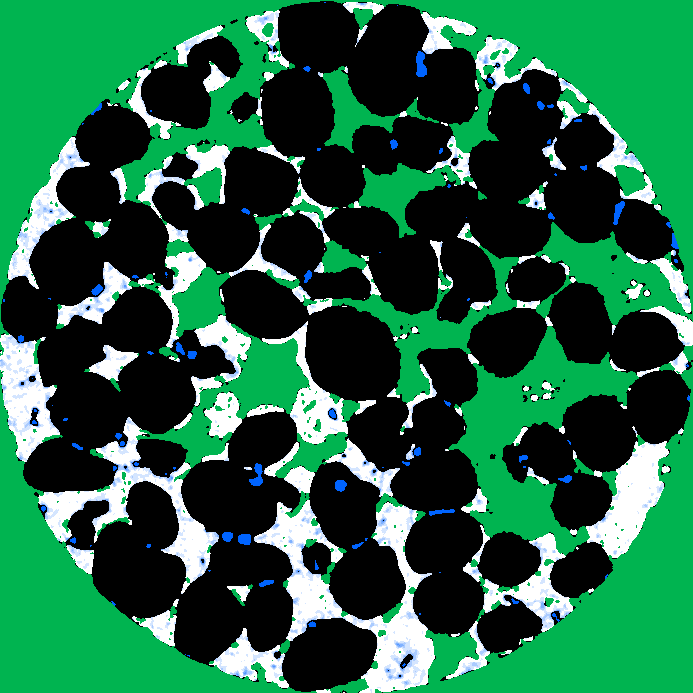

In [29]:
for i in range(height):
    for j in range(width):
        if image_brine[i,j] == 255:
        #if image_original[i,j] > gas and image_original[i,j] < grain:
            for k in range(1,num-1):
                if image_original[i,j] > array_gs[k-1] and image_original[i,j] < array_gs[k]: # set hydrate-brine mixture to discrete color map
                    rgbArray2[i,j,0] = array_r[k-1]
                    rgbArray2[i,j,1] = array_g[k-1]
                    rgbArray2[i,j,2] = array_b[k-1]
            if image_original[i,j] > gas and image_original[i,j] < array_gs[0]: # for low salinity brine (~pure hydrate)
                rgbArray2[i,j,0] = 255
                rgbArray2[i,j,1] = 255
                rgbArray2[i,j,2] = 255
        if image_original[i,j] < gas: # set gas = green
            rgbArray2[i,j,0] = 0 
            rgbArray2[i,j,1] = 180
            rgbArray2[i,j,2] = 80
        if image_grain[i,j] == 255: # set grains = black
            rgbArray2[i,j,0] = 0
            rgbArray2[i,j,1] = 0
            rgbArray2[i,j,2] = 0
        if image_original[i,j] > 64000: # for high salinity brine
            rgbArray2[i,j,0] = 0
            rgbArray2[i,j,1] = 100
            rgbArray2[i,j,2] = 255     
            
segmented2 = Image.fromarray(rgbArray2)
segmented2.save('13d_400_brine_seg.png')
segmented2

### Create Segmented Image (with Salinity Calculation)

Previous segmentation couldn't capture the brine/hydrate meniscus between grains. In this method I segment the grain, brine, and hydrate together using the following procedure in Fiji/ImageJ and then apply a median filter to get rid of the remaining grain coating artefact. 

(1) threshold grains first, including grain coating artifact
(2) threshold brine/hydrate with grain coating artifact
(3) apply median filter to (2) to get rid of grain coating artifact
(4) add (3) to (1) to get grain/brine/hydrate segmentation without grain coating artifact (ideally)
(5) apply another mean filter if necessary to remove holes in grain (using python)
(6) to extract brine/hydrate without grain coating artifact, subtract (5) and (1)

In [48]:
height, width = image_original.shape
rgbArray3 = np.zeros((height,width,3), 'uint8')

num = 7 # number of divisions for discrete color bar
gas = 13107; # grayscale threshold for gas
grain = 32639; # grayscale threshold for grain

array_KI = np.linspace(0,6,num) # array for KI cutoffs
array_r = np.linspace(255,0,num) # array for r cutoffs of discrete color map
array_g = np.linspace(255,100,num) # array for g cutoffs of discrete color map
array_b = np.linspace(255,255,num) # array for b cutoffs of discrete color map

ct_sand = 51000
ct_sand_calibration = 23500
offset = 3690
array_gs = np.round((array_KI * 1972 + 7445) * (ct_sand/ct_sand_calibration) + offset,0) 
    # array for grayscale cutoffs, from calibration
    # adjusted by a multiplier since mean gs of sand is different than mean gs of sand from calibration
    # adjusted by a offset to match the scaling calibration equation at bulk wt% of 4.4 KI
#array_gs = np.linspace(gas,grain,num)
    # array for grayscale cutoffs, using idealized linear scale

df = pd.DataFrame({'Grayscale':array_gs,'Bulk wt% of KI':array_KI,'R':array_r,'G':array_g,'B':array_b})
df.head(num)

Grayscale  Bulk wt% of KI      R           G      B
0    19847.0             0.0  255.0  255.000000  255.0
1    24127.0             1.0  212.5  229.166667  255.0
2    28407.0             2.0  170.0  203.333333  255.0
3    32686.0             3.0  127.5  177.500000  255.0
4    36966.0             4.0   85.0  151.666667  255.0
5    41246.0             5.0   42.5  125.833333  255.0
6    45525.0             6.0    0.0  100.000000  255.0

In [ ]:
for i in range(height):
    for j in range(width):
        if image_original[i,j] < gas: # set gas = green
            rgbArray3[i,j,0] = 0 
            rgbArray3[i,j,1] = 180
            rgbArray3[i,j,2] = 80
        #if image_grain[i,j] == 255: # set grains = black
        if image_original[i,j] > grain and image_original[i,j] < 65000:
            rgbArray3[i,j,0] = 0
            rgbArray3[i,j,1] = 0
            rgbArray3[i,j,2] = 0
        if image_grain_and_brine[i,j] == 255:
        #if image_original[i,j] > gas and image_original[i,j] < 65000:
            for k in range(1,num-1):
                if image_original[i,j] > array_gs[k-1] and image_original[i,j] < array_gs[k]: # set hydrate-brine mixture to discrete color map
                    rgbArray3[i,j,0] = array_r[k-1]
                    rgbArray3[i,j,1] = array_g[k-1]
                    rgbArray3[i,j,2] = array_b[k-1]
            if image_original[i,j] > gas and image_original[i,j] < array_gs[0]: # for low salinity brine (~pure hydrate)
                rgbArray3[i,j,0] = 255
                rgbArray3[i,j,1] = 255
                rgbArray3[i,j,2] = 255
        if image_original[i,j] > 64000: # for high salinity brine
            rgbArray3[i,j,0] = 0
            rgbArray3[i,j,1] = 100
            rgbArray3[i,j,2] = 255     
            
segmented3 = Image.fromarray(rgbArray3)
segmented3.save('13d_400_brine_seg1.png')
segmented3

### Filtering

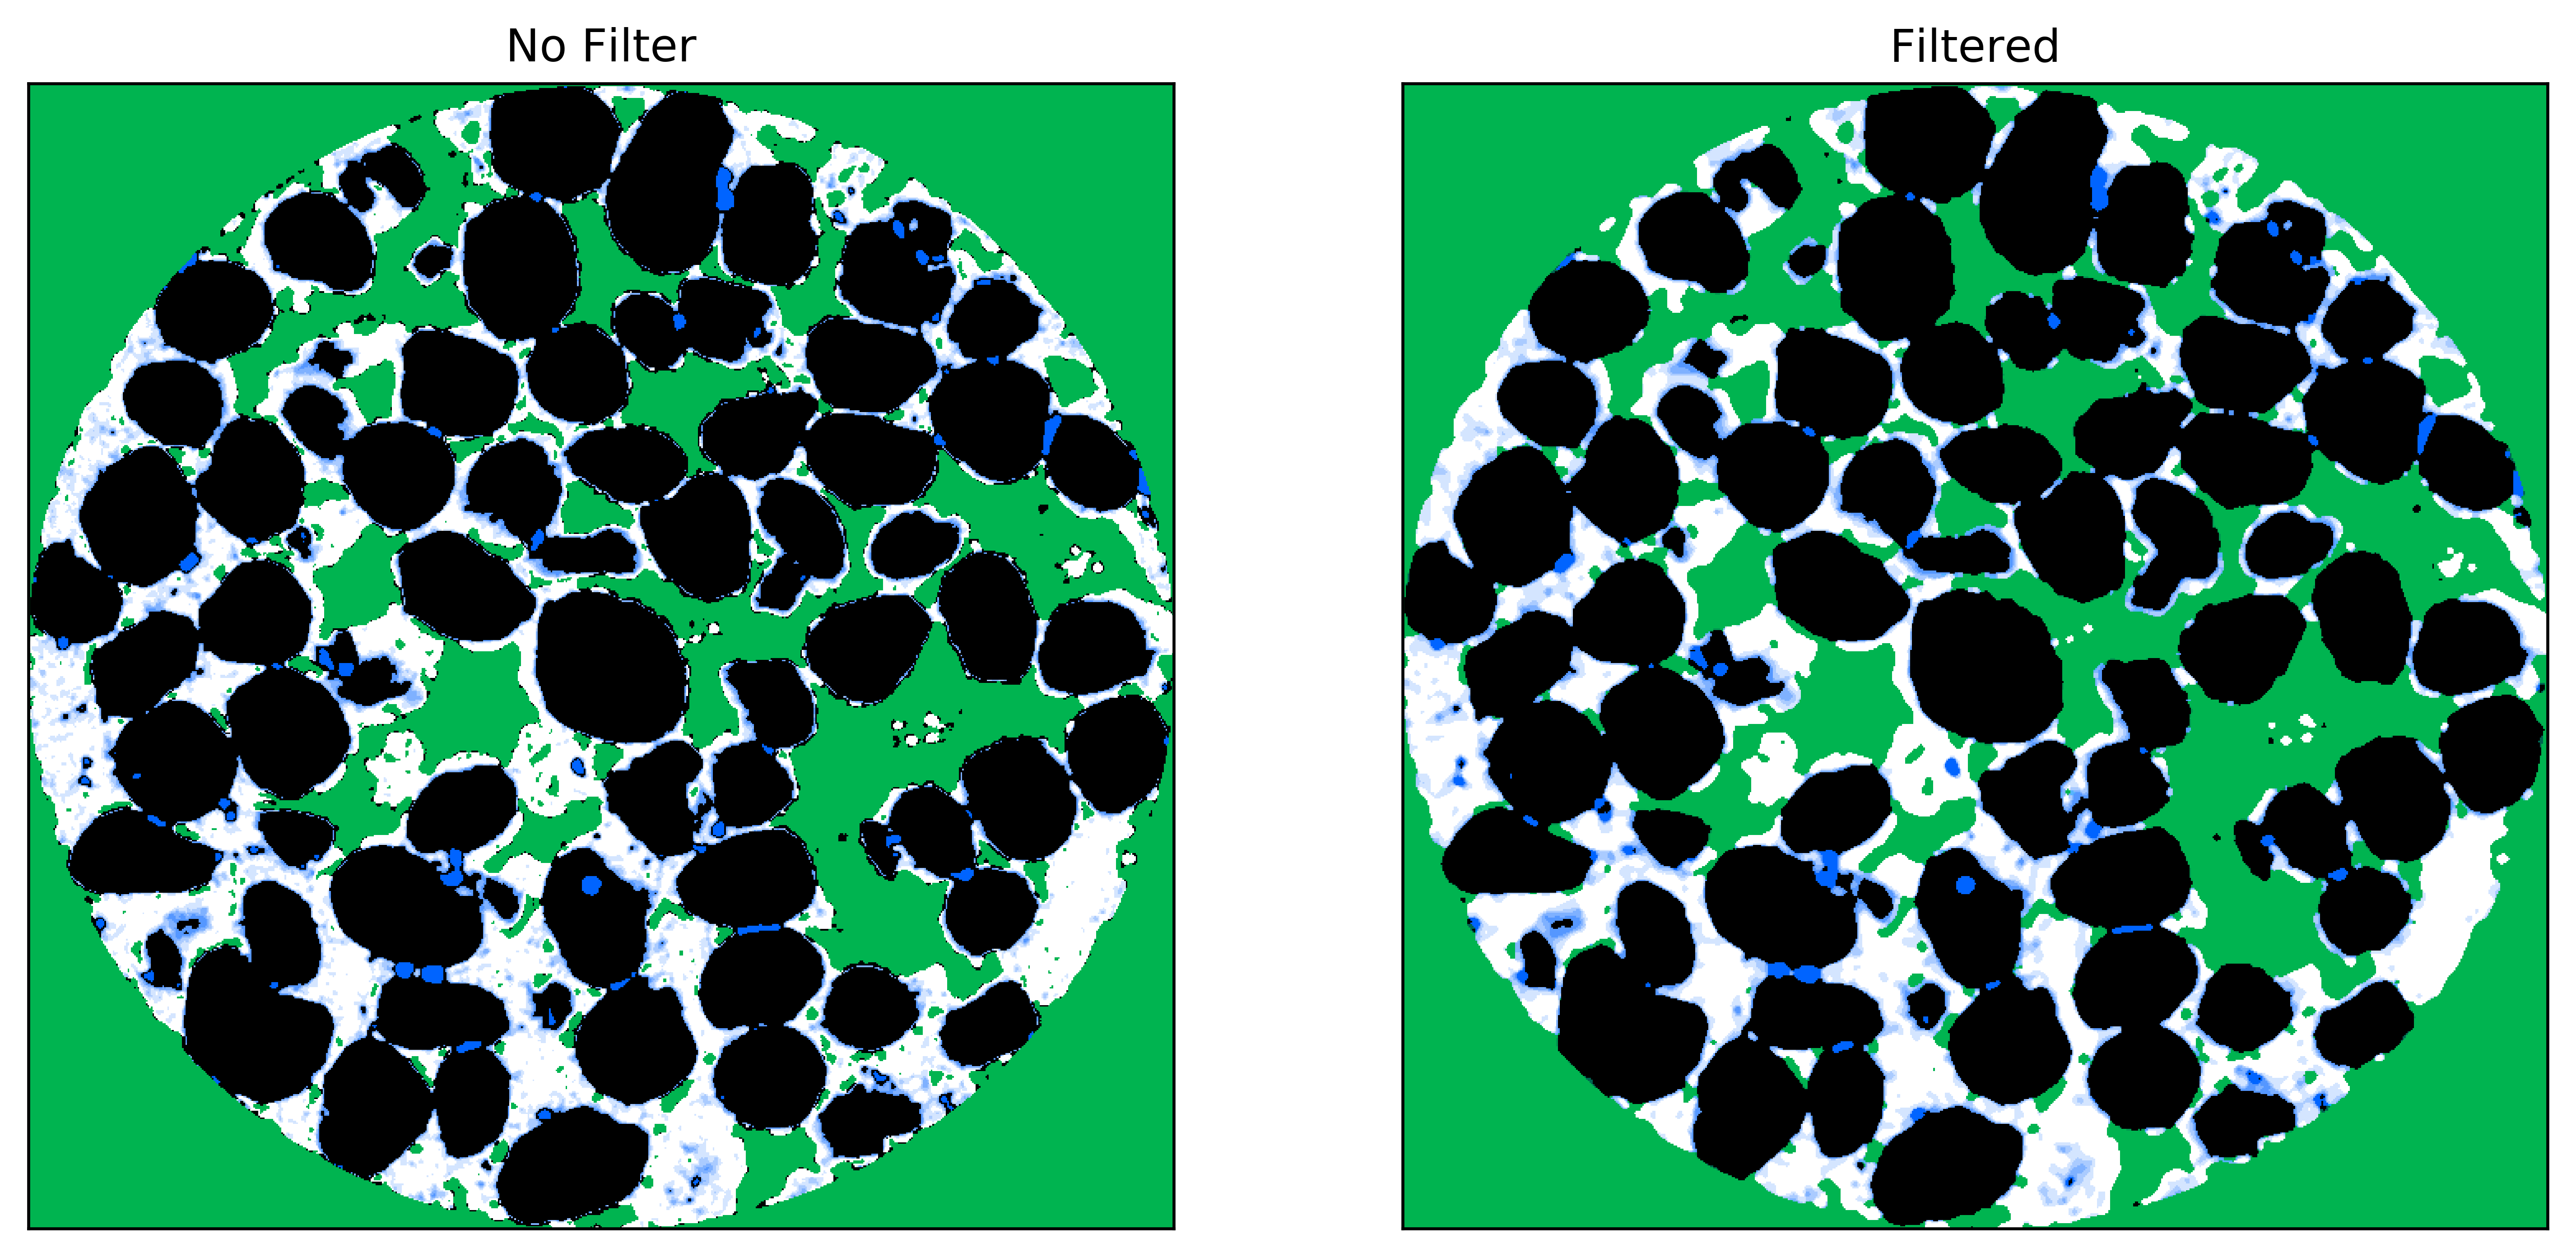

True

In [60]:
import cv2
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=600, facecolor='w', edgecolor='k')

image = cv2.imread('13d_400_brine_seg1.png')
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

kernel = np.ones((5,5),np.float32)/25
image_after = cv2.medianBlur(image,5)
#image_after = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
RGB_image_after = cv2.cvtColor(image_after, cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(RGB_image),plt.title('No Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(RGB_image_after),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('13d_400_brine_seg1_filtered.png',image_after)

### Comparision

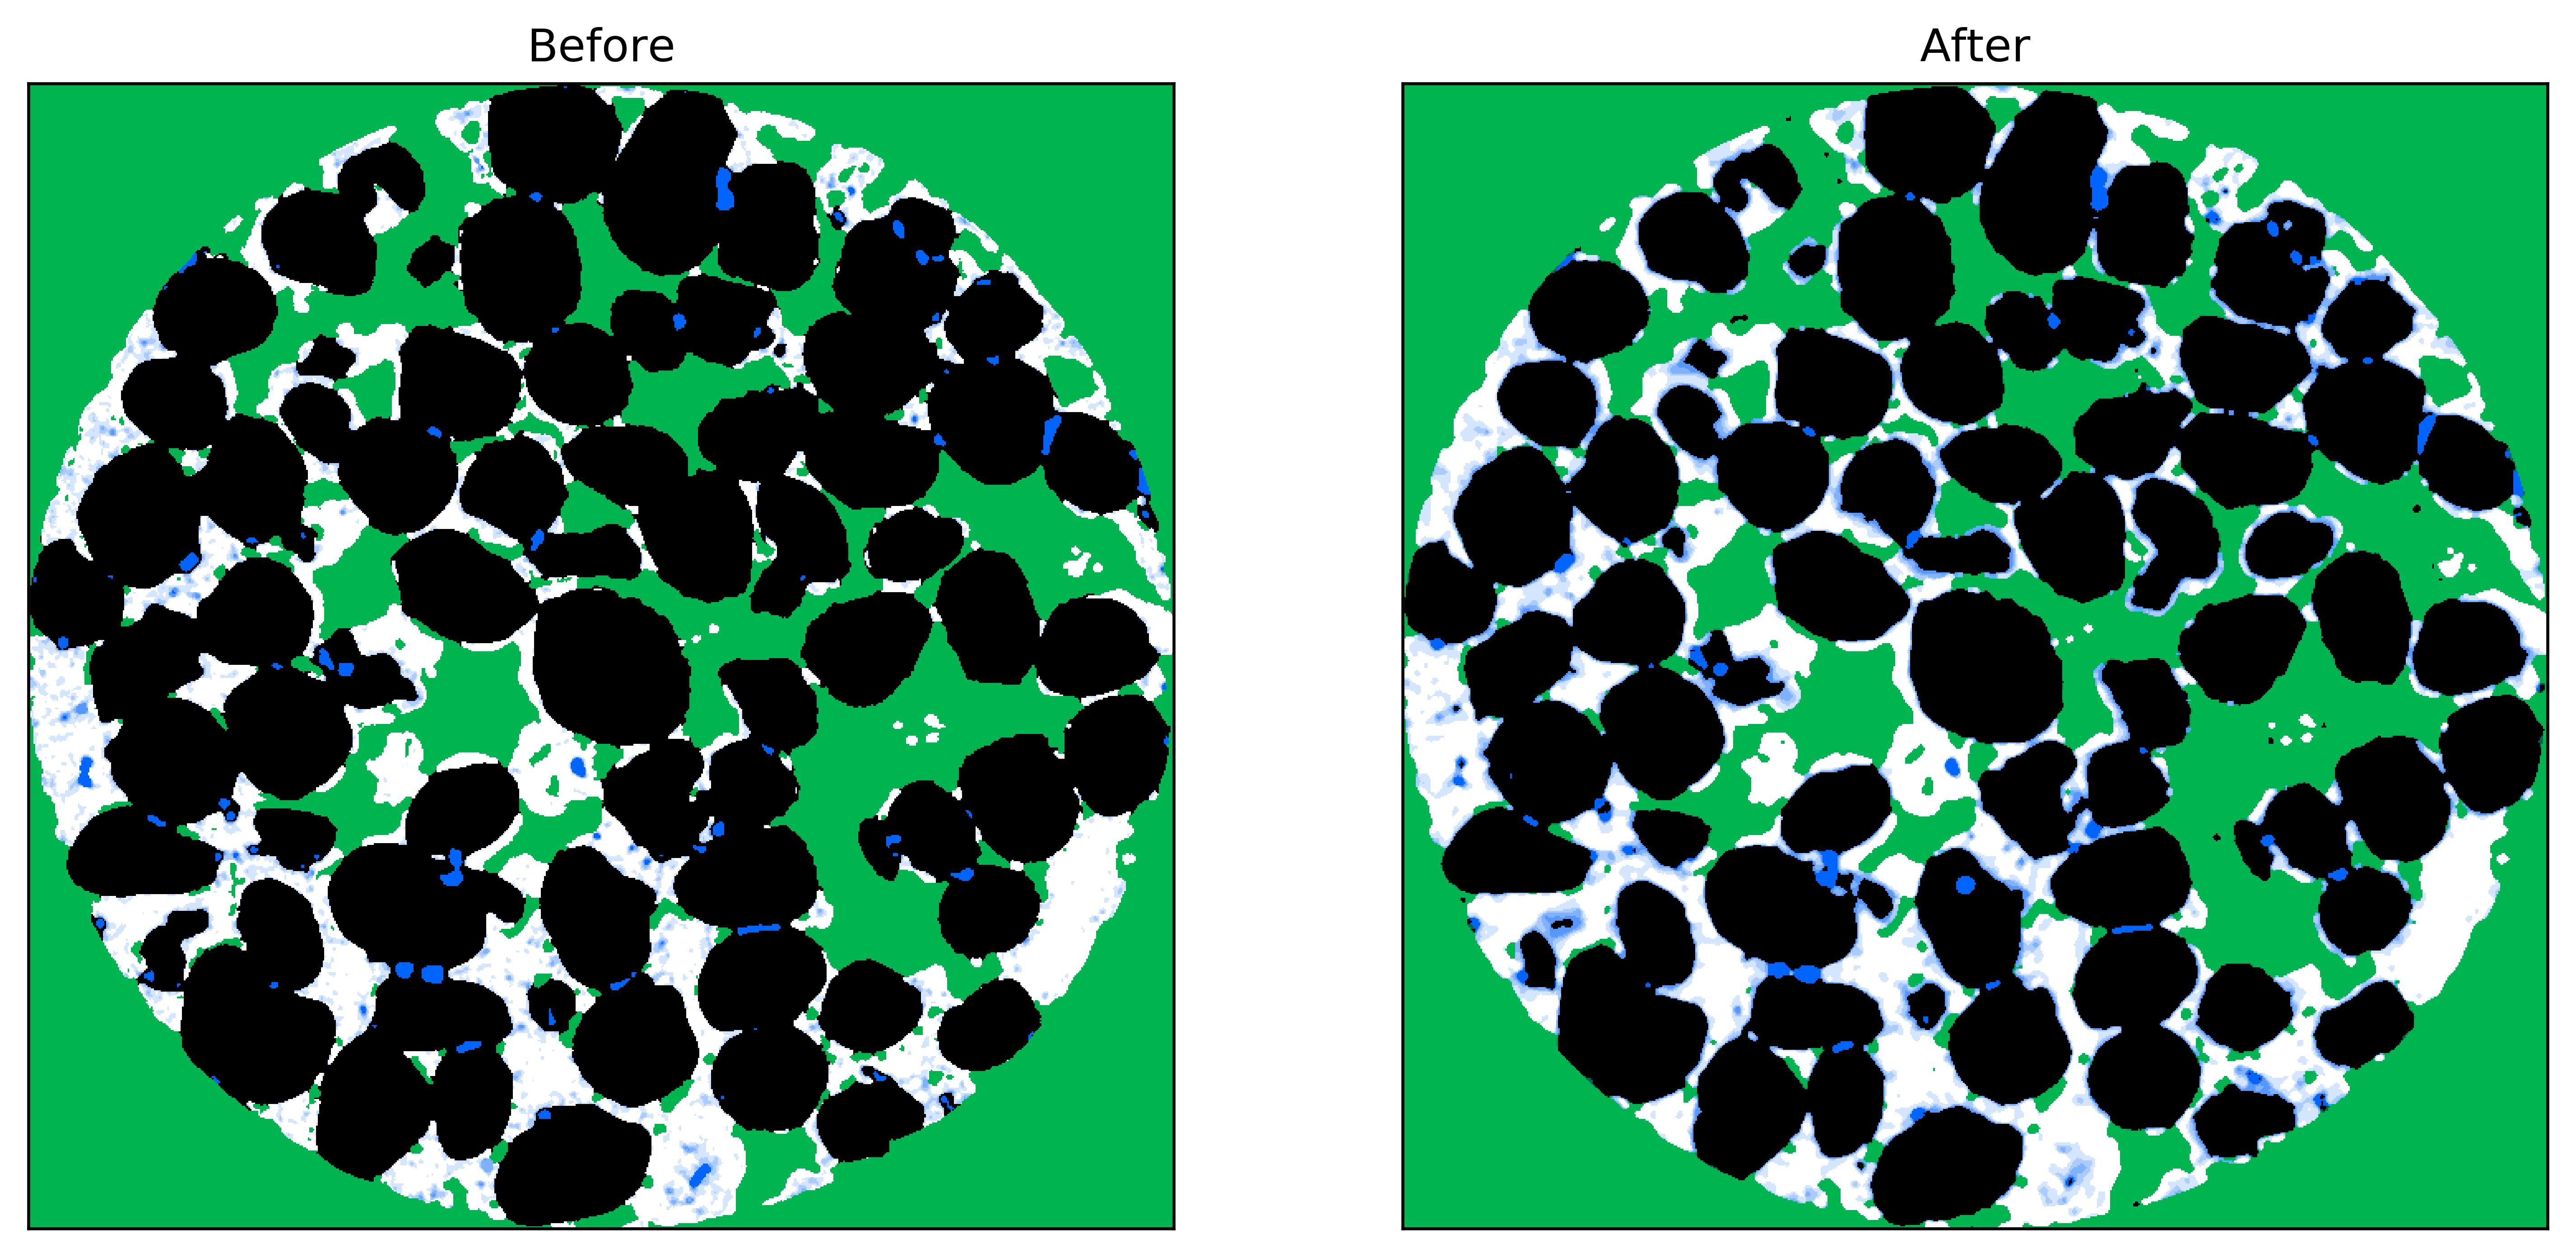

In [59]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=600, facecolor='w', edgecolor='k')

image1 = cv2.imread('13d_400_brine_seg_edited.png')
RGB_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('13d_400_brine_seg1_filtered.png')
RGB_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(RGB_image1),plt.title('Before')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(RGB_image2),plt.title('After')
plt.xticks([]), plt.yticks([])
plt.show()